# Alpha lifetime

An script to compute alpha lifetime.

In [61]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams

sys.path.append('/Users/alej/Desktop/Valencia/nextic/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2

from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running on  Mon May 22 10:45:36 2017


In [62]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-22 10:45:37


In [63]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [64]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [65]:
#run_number = 3628
#run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number = 3733
#run_number = 3741
#run_number = 3753
#run_number = 3756
#run_number = 3758
#run_number = 3762
#run_number = 3767
#run_number = 3769
#run_number = 3772
#run_number = 3774
#run_number = 3782
#run_number = 3784
#run_number = 3788
#run_number = 3790
#run_number = 3793
#run_number = 3795
#run_number = 3822
#run_number = 3824
#run_number = 3826
#run_number = 3829
#run_number = 3855
#run_number = 3883

#run_number = 3614

#run_number =  3988
#run_number =  3998
#run_number = 4002
#run_number = 4021
#run_number = 4027
#run_number = 4029
#run_number = 4035
#run_number = 4050
#run_number = 4051
run_number = 4052




In [66]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [67]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join(os.environ['IC_DATA'], 'LSC/kdst/dst_{}.root.h5'.format(run_number,run_number))
                       
print("ifile:", ifile)

ifile: /Users/alej/Desktop/IC_DATA/LSC/kdst/dst_4052.root.h5


In [68]:
full = load_dst(ifile)
print(len(full))
full.head()

15001


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.495393e+09,0,1,300.0,241.572250,1387.757742,632875.0,34.655125,6297.290527,...,652412.5,9,19.5375,19.5375,-187.324307,67.273877,199.038113,2.796807,5.806708,6.531555
1,2,1.495393e+09,0,1,325.0,374.859192,2169.021833,210725.0,46.096688,2690.888428,...,654612.5,6,443.8875,443.8875,-42.715638,53.445611,68.418266,2.245071,6.505280,6.348049
2,3,1.495393e+09,0,1,325.0,367.220856,2116.805702,241800.0,45.181688,2652.224854,...,654562.5,7,412.7625,412.7625,27.600334,-134.120231,136.930693,-1.367842,6.697461,6.749256
3,4,1.495393e+09,0,1,325.0,356.179871,2028.136776,357200.0,47.574438,4450.619141,...,655062.5,11,297.8625,297.8625,38.394004,-30.695097,49.155757,-0.674422,7.650240,8.285649
4,5,1.495393e+09,0,1,350.0,657.748535,4293.503202,106475.0,60.924125,2923.556152,...,656462.5,10,549.9875,549.9875,-45.797962,-36.412902,58.509424,-2.469861,7.708970,8.665265


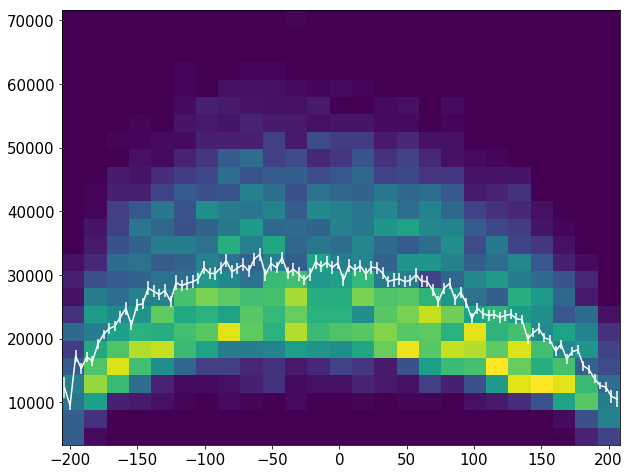

In [69]:
plt.figure(figsize=(10,8))
c = full
c = full[full.Y > -100]
c = c[c.Y <  100]
#c = c[c.Z > 100]
#plt.scatter(c.X, c.S2e)
a = fitf.profileX(c.X, c.S2e, 100)
plt.hist2d(c.X, c.S2e, bins=25)
#plt.ylim((50000,150000))
plt.errorbar(*a, c='white')
plt.show()


In [70]:
fid = full[full.R     <  100*units.mm] # michel sorel cuts

In [71]:
len(fid)

4133

In [72]:
len(full)

15001

In [73]:
r = event_rate(full)

In [74]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 4.609308769711264 evts/s


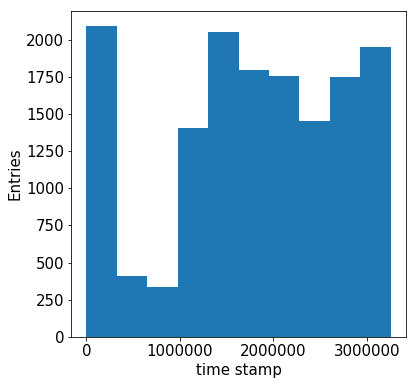

In [75]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

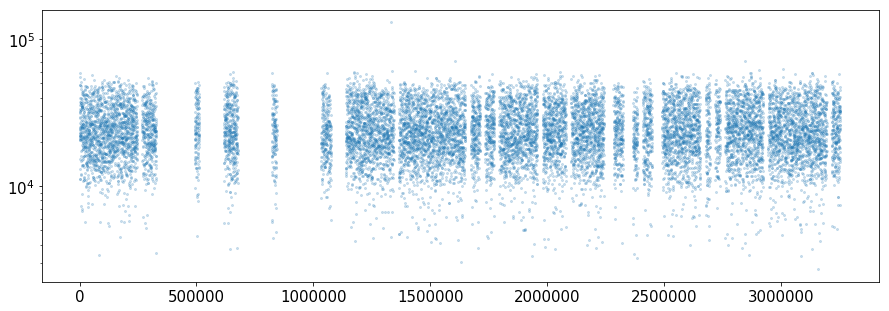

In [76]:
plt.figure(figsize=(15,5))
plt.scatter(1e+3*(full.time - full.time[0]), full.S2e, alpha=.2, s=4)
plt.yscale('log')
plt.show()

In [77]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

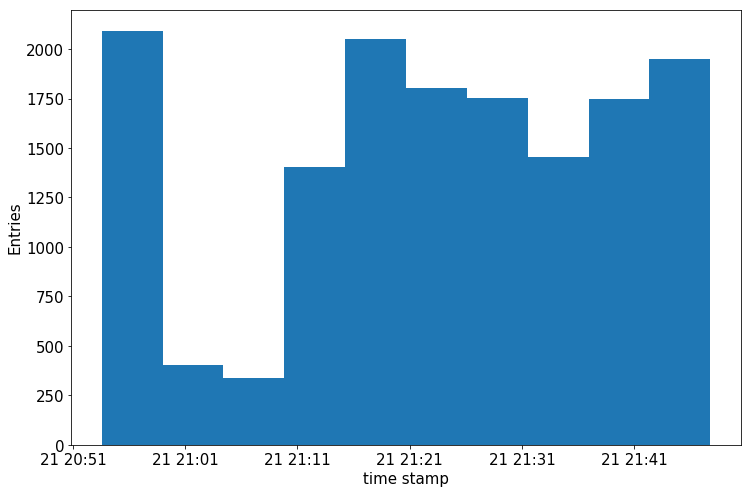

In [78]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [79]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [80]:
print(st)

2017-05-21 21:47:47


In [81]:
print(full.time.index[-1])

15000


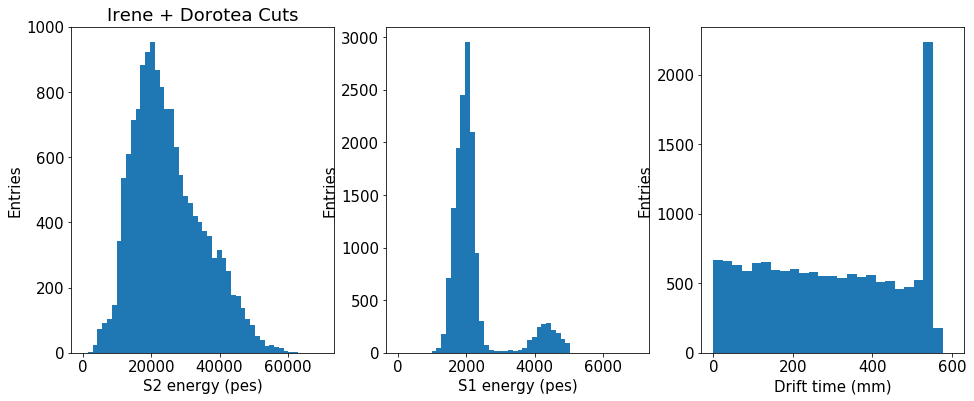

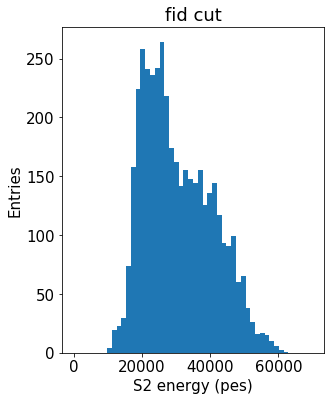

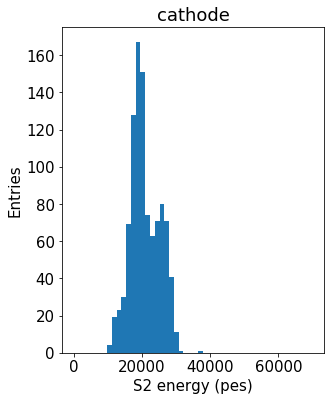

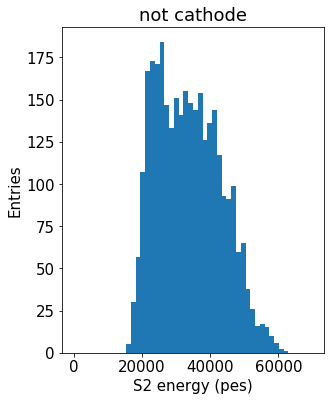

In [84]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

#ax = plt.subplot(1, 3, 2)
#plt.hist(fidc.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fidc.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fid.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fid cut')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 2)
plt.hist(fid[in_range(fid.Z, 500, 600)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('cathode')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 3)
plt.hist(fid[in_range(fid.Z, 0, 500)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('not cathode')

#ax = plt.subplot(1, 3, 2)
#plt.hist(fid.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fid.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

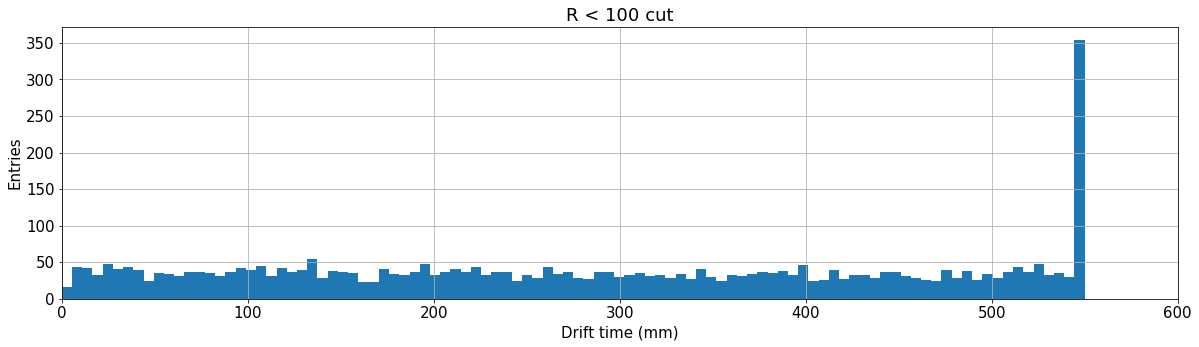

In [85]:
plt.figure(figsize=(20,5))
b = plt.hist(fid.Z, 100, (0, 550))
plt.xlim(0,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('R < 100 cut')




### Dependence with Z all alphas

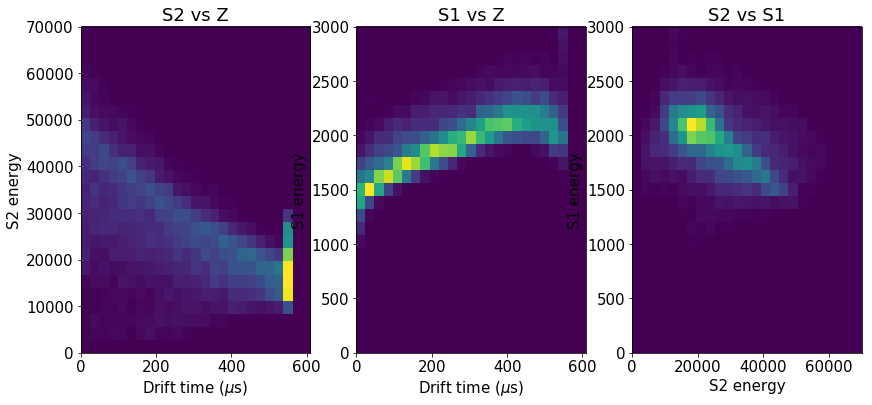

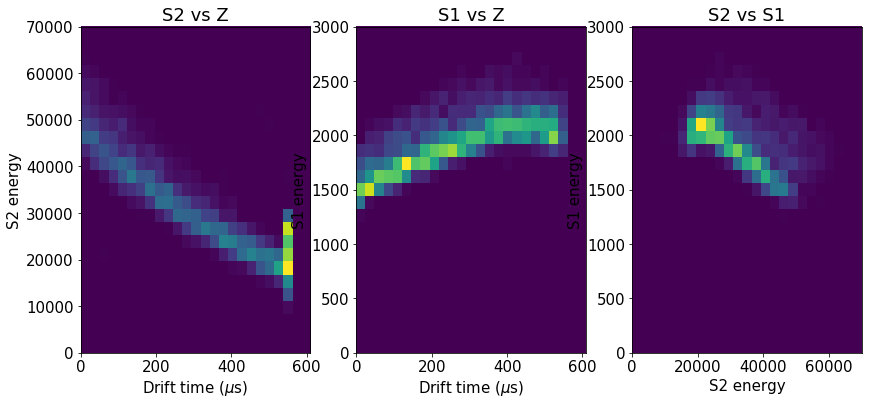

In [86]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(fid.Z, fid.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(fid.Z, fid.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(fid.S2e, fid.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [87]:
#core = blk[blk.R < 100]
core = fid
print("Ratio wrt full:", len(core)/len(full))

cathode = full[full.Z > 500]
#core2 = core2[core2.Z < 500]

#core= fid

Ratio wrt full: 0.2755149656689554


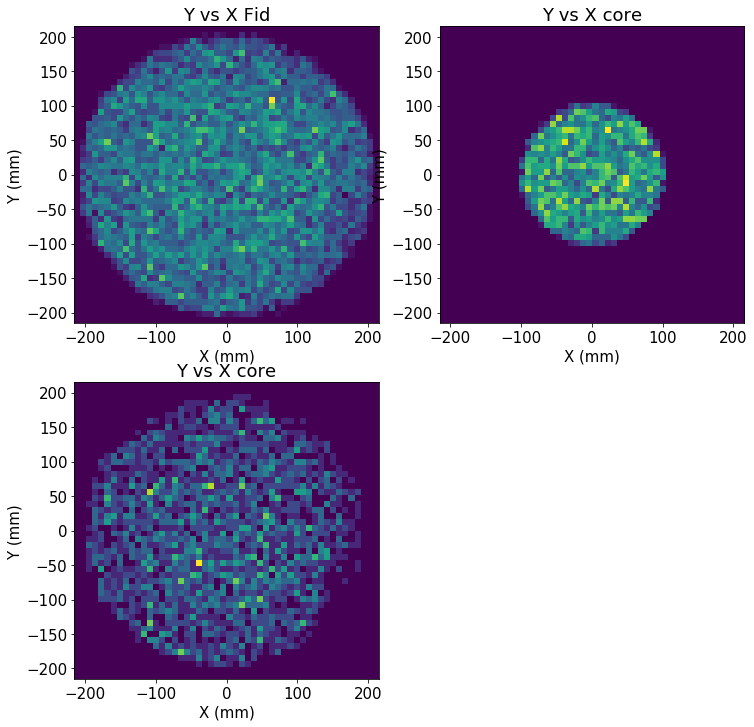

In [88]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,12)
plt.figure(figsize=figsize)
ax = plt.subplot(2, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(2, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

ax = plt.subplot(2, 2, 3)
plt.hist2d(cathode.X, cathode.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

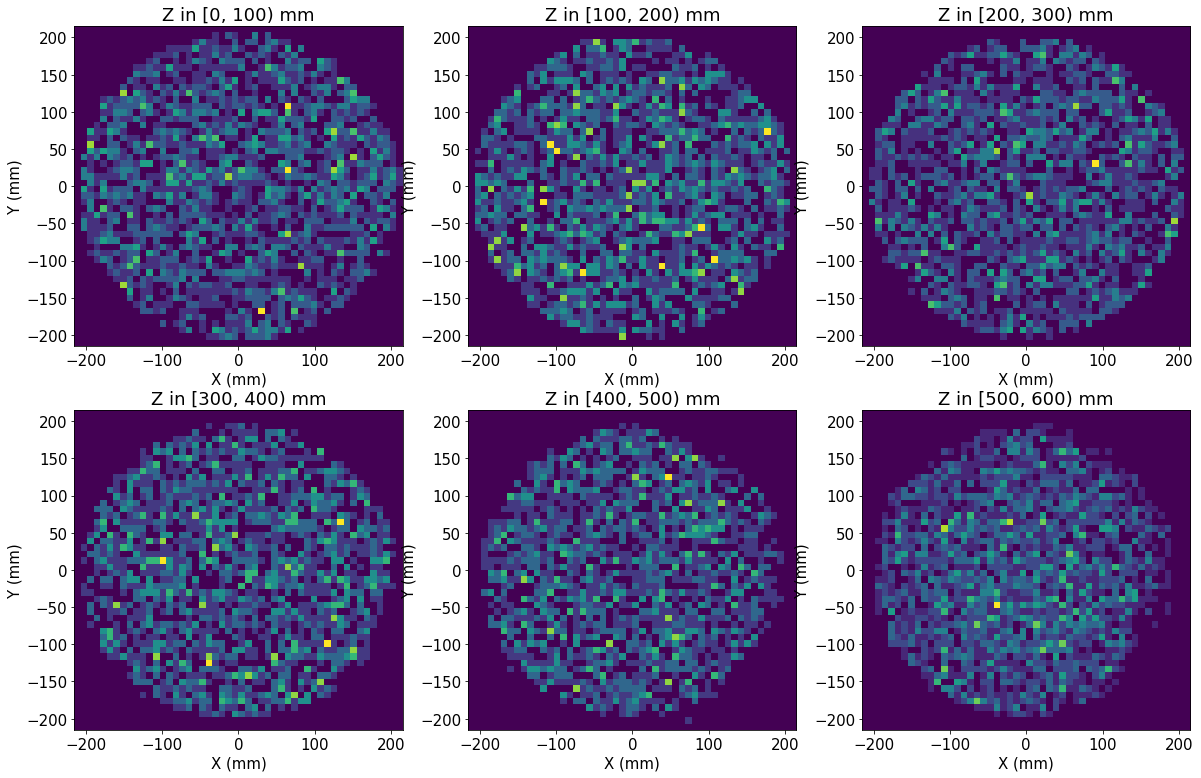

In [89]:
figsize=(20,20)
plt.figure(figsize=figsize)
ax = plt.subplot(3, 3, 1)

for i in range(6):

    ax = plt.subplot(3, 3, i+1)
    plt.hist2d(full[in_range(full.Z, i*100, (i+1)*100)].X, full[in_range(full.Z, i*100, (i+1)*100)].Y,
               (50, 50), range=(xrange, yrange))
    labels("X (mm)", "Y (mm)")
    plt.title('Z in [' + str(i*100) + ', ' + str((i+1)*100) + ') mm')

### Z correction for bulk 

#### S2

fit par[0] = 50789.000370889335 error = 382.927712430409
fit par[1] = -552.6661497095189 error = 9.457042403966804
degrees of freedom = 2
chi2 = 1.2747178925468652


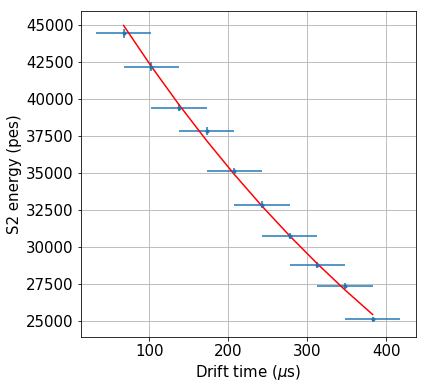

In [90]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
-F.values[1]
print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

In [91]:
-F.values[1]
F

FitFunction(fn=<function fit.<locals>.<lambda> at 0x117c27510>, values=array([ 50789.00037089,   -552.66614971]), errors=array([ 382.92771243,    9.4570424 ]), chi2=3.9093679391226388, pvalue=0.00028637080927120168)

#### Constrain fiducial in z

In [92]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.14832344510365975


#### Fit S2 in fiducial 

fit par[0] = 39521.135276767454 error = 472.5420970355772
fit par[1] = -564.7931033038332 error = 15.055985564817128
degrees of freedom = 2
chi2 = 1.373687063601589


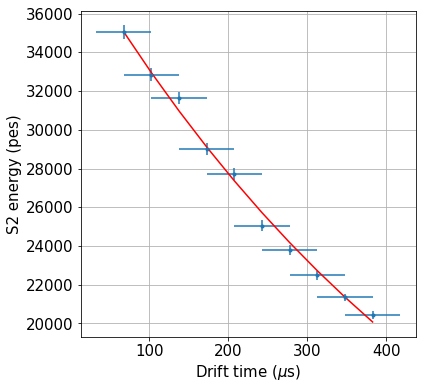

In [93]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(full.Z, full.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

In [94]:
F

FitFunction(fn=<function fit.<locals>.<lambda> at 0x113b61730>, values=array([ 39521.13527677,   -564.7931033 ]), errors=array([ 472.54209704,   15.05598556]), chi2=7.3658302753096461, pvalue=7.1256808915828231e-09)

### S2 corrections

In [95]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-05-21 20:53:33 t1 = 2017-05-21 21:47:47


using data set with length 4133
t0 = 2017-05-21 20:53:33 (index = 0) t1 = 2017-05-21 21:47:47 (index = 4133)
bin length = 826
 ---fit over events between 0 and 825
time0 = 2017-05-21 20:53:33 time1 = 2017-05-21 21:10:56
size of time leg = 825
fit par[0] = 51632.33754417243 error = 740.0065150296177
fit par[1] = -537.1030156603925 error = 17.605600374608
degrees of freedom = 2
chi2 = 1.1725583089048313
 ---fit over events between 826 and 1651
time0 = 2017-05-21 21:10:56 time1 = 2017-05-21 21:20:03
size of time leg = 825
fit par[0] = 50575.6404018237 error = 921.9099899697617
fit par[1] = -547.482614094057 error = 22.325666921930864
degrees of freedom = 2
chi2 = 1.7822495827461353
 ---fit over events between 1652 and 2477
time0 = 2017-05-21 21:20:03 time1 = 2017-05-21 21:29:08
size of time leg = 825
fit par[0] = 50996.80380013676 error = 396.85861383302466
fit par[1] = -548.7753290847426 error = 9.671329872671315
degrees of freedom = 2
chi2 = 0.697693781174323
 ---fit over events between

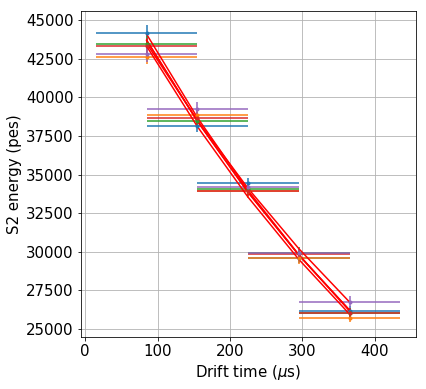

In [96]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=core, zrange=(50,400), Erange=(1e+3, 80e3), nbins=5)

In [97]:
plot_options()

In [98]:
TSTAMP

['2017-05-21 21:10:56',
 '2017-05-21 21:20:03',
 '2017-05-21 21:29:08',
 '2017-05-21 21:39:09',
 '2017-05-21 21:47:46']

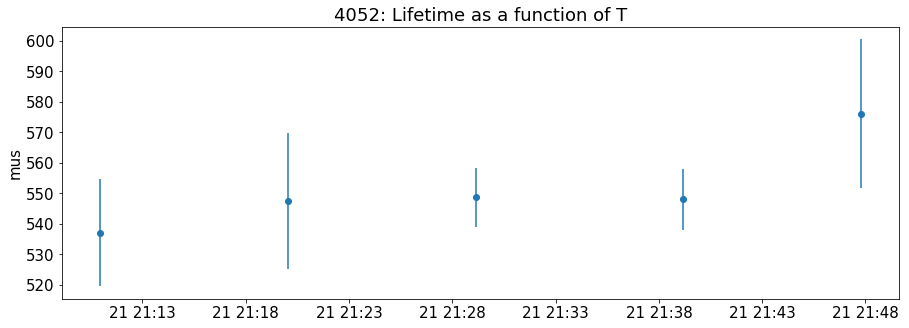

In [99]:
figsize=(15,5)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))
plt.show()



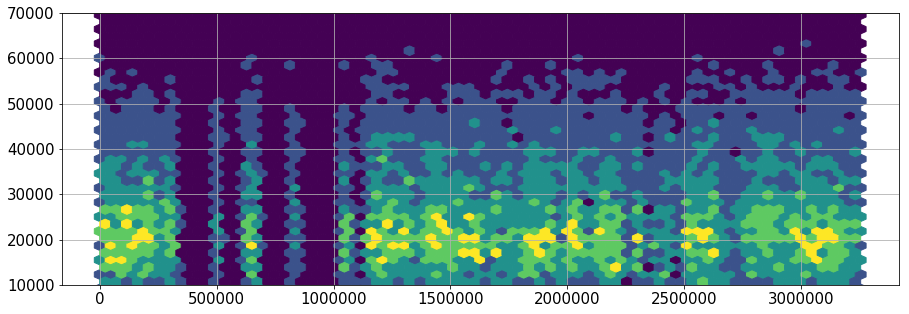

In [100]:
plt.figure(figsize=figsize)
plt.hexbin(1e+3*(full.time - full.time[0]), full.S2e, bins=5, gridsize=70)
#plt.yscale('log')
plt.ylim(10000,70000)
#plt.ylabel('S2e')
plt.grid(True)
plt.show()